# KERAS MODEL WITH TENSORFLOW BACKEND

## Preprocessing the Data

### loading the data
- cifar10: 
    - was loaded from a folder online
    - is a dataset for image classification
    - included in the tensorflow.keras.datasets module
    - is imported from data.py, it outputs training and testing data partitions (x_train, y_train, x_test, and y_test)
- to note:
    - when i decided on using cifar10 as my dataset, i tried to upload them from keras/tensorflow and pytorch, but was unsuccessful due to issues with library verisons.
    - in order to combat this, i manually downloaded the data from online and processed it via the script in data.py.

In [2]:
from data import load_cifar10

root_dir = "//Users//yanajakhwal//Desktop//Projects//img_classification//cifar10_data//cifar-10-batches-py"
x_train, y_train, x_test, y_test = load_cifar10(root_dir)

### the shapes of the dataset splits
- ___.shape => __ images of size __ by __ with __ colour channels 
    - 3 is RBG
- ___.shape => __ labels corresponsiding to the training images

In [3]:
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

# should print:
#     Training data shape: (50000, 32, 32, 3)
#     Training labels shape: (50000,)
#     Test data shape: (10000, 32, 32, 3)
#     Test labels shape: (10000,)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


### preprocessing the data
- why normalize:
    - pixels range from [0,255] for the RGB channels-- so dividing by 255 scales to a range of [0,1].
        - this is done to ensure that the inputs the the neural network are uniform
        - avoids the domination of features due to their larger numerical values
    - performance increases
        - leads to reducing the number of epochs (iterations) required
        - consistency with the numerical data
    - improves convergence speed of gradient descent. 
        - the gradient descent algorithm minimizes the loss function of the model
        - the loss function measures how far off the model's predictions are from the target values 

In [4]:
# normalizing the pixel values of images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

### quantifying the categorical dependent train and test data splits
- cifar-10 utilizes 10 classes where each image is respresented using numbers [0,9]
- categorical crossentrophy is utilized
    - measures the difference between the predicted distribution and the true distribution (one-hot encoded data)
        - one-hot encoding: different classes are representeed by vectors of 1 and 0(s).
        - categorical crossentrophy works only if the data is one-hot encoded


In [5]:
from tensorflow.keras.utils import to_categorical

# since the cifar-10 dataset is a categorical crossentropy loss
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### using data augmentation
- why use data augmentation:
    - increases the dataset's diversity with modified versions of images.

- ImageDataGenerator exposes the images to a wider variety of input conditions during training with parameters that specify the range that the data can be modified within.
- then the independent training data is fitted to the image generator.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# creates an ImageDataGenerator for data augmentation
data_aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1 
)

# fits the generator to the training data
data_aug.fit(x_train)

### visualizing the images
- the training data that was augmented can now be visualized 

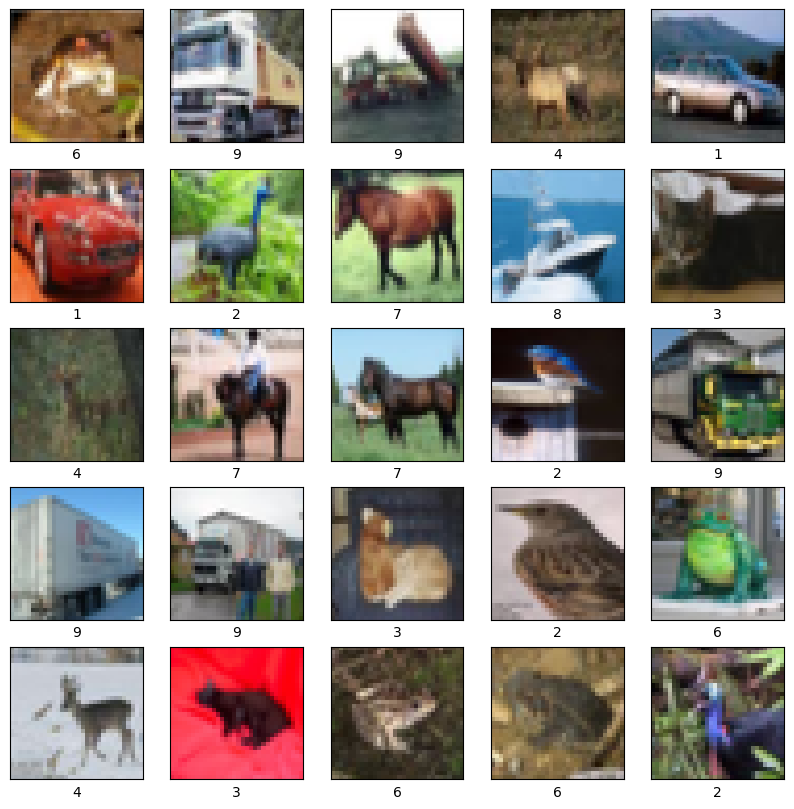

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(np.argmax(y_train[i]))
plt.show()

# should display 25 images from the training set

## Building a convolutional neural network (CNN) for image classification

### model architecture
- why use a CNN?
    - a CNN is a neural network designed for processing structured grid-like-data (like images).
    - they utilize convulutional layers that apply filters (kernels) to local regions of the input image.
         - effeciently capture features like edges (lower layers)
         - more complex detetct patterns like shapes or entire objects (higher layers)
         - using different levels of learn features (lower to higher layers) mimicks the human process of precieving visual information
    - the same filter is applied to different parts of the image and so teh network will lern a set of filters which can detect features anywhere in the image.
        - this reduced the number of parameters in the network compared to the fully connected layers of traditional neural networks
        - so CNNs are more efficient and less prone to overfitting (especially when dealing with large images)
    - benefits of translation invariance:
        - CNNs use pooling layers (ex: max pooling), which downsample the feature maps, the network becomes less sensitive to the exact location of features in the image.
        - allows CNNs to recognize objects in images regardless of where they appear. For instance, a CNN trained to recognize a cat will be able to identify the cat whether it’s in the center or in the corner of the image
    - well-suited for large sets of image based data sets.



In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

### building the model
- initalize the model with the sequential model from tensorflow.keras.models.
- convolutional layer:
    - 32 filters (kernels) with the filter size of 3x3 pixels
        - with each layer the filter double to captur emmore complex patterns and features
    - 'relu' is a rectified linear unit whcih converts negative pixel values to 0.
    - shape of input is 32x32 pixed with 3 colour channels (RGB) for the first layer
- pooling layers:
    - downsamples the feature maps by taking the maximum value in each 2x2 region 
        - reduced the spatial dimesion by half (ex: 32x32 => 16x16) which reduced numbers of parameters and compuations in the networkm also provides translation invariance
- flattening layer:
    - converts the three-dimensional output into a one-dimensional vector (i.e: flattening)
    - the vector length is calculated using the previous layers' product (ex: 32 x 64 x 128)
- dense layer:
    - fully connected later with 128 neurons (the amount of kernels of the last convolutional layer) which are connected to every neuron in the previous layer.
- dropout layer:
    - depneding on the input it will randomly set a percentage of the input units to 0
    - prevents overfitting which ensures a lack of reliancy on single features or subsets of features
- output layer:
    - final layer which uses 10 neurons corresonding to the 10 classes in the CIFAR-10 dataset
    - the activation converts the outputs into probablities.
        - the probabilities sum up to 1.

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

/Users/yanajakhwal/Desktop/Projects/img_classification/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### compiling the model
- configures the learnign process before the model starts training.
- specifies the optimizer, loss function and metrics the model utilizes during training and evaluation
- optimizer = Adam():
    - an algorithm that updates the weights of the neural network
        - minimizes the loss function
    - Adam is commonly used for opimization with deep learning
        - combines the best properties of two other optimizers AdaGrad (good for sparse gradients) and RMSProp (good for non-stationary settings)
- loss = 'categorical_crossentropy':
    - loss is the calculation of the variance between the model's predictions and the actual outputs
    - compares the predicted probability distribution over the classes (from the softmax output layer) to the true distribution (one-hot encoded labels).
        - the loss is higher when the predicted probability for the correct class is low
    categorical crossentropy encorages the model to putput higher probabilities for the correct class and the opposite
- metrics = ['accuracy']:
    - accuracy is the percentage of predictions that match the true labels
    - after each epoch, the model calculates the accuracy by dividing the number of correct predictions by the total number of predictions.

In [10]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',  # using categorical crossentropy for multi-class classification
              metrics=['accuracy'])

## Training the model

### fitting the model to the augmented train data splits 
- epoch: the model will iterate over the entire training dataset 50 times
- batch_size: number of samples
    - larger sizes are more computationally efficient but might lead to less frequent updates (could slow the learning)
- validation data: used to monitior the performance of the epochs
    - using test data is not typical but necessary with a lack of data as validatipon sets are meant to be an unbiased evaluation metric

In [11]:
history = model.fit(x_train, y_train, 
                    epochs=50, 
                    batch_size=64,
                   validation_data=(x_test, y_test))  # uses x_test, y_test if no validation set

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 87s 110ms/step - accuracy: 0.2818 - loss: 1.9131 - val_accuracy: 0.5010 - val_loss: 1.3748
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - accuracy: 0.5109 - loss: 1.3740 - val_accuracy: 0.5603 - val_loss: 1.2126
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.5616 - loss: 1.2281 - val_accuracy: 0.6088 - val_loss: 1.1050
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.6129 - loss: 1.1014 - val_accuracy: 0.6381 - val_loss: 1.0118
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 49s 62ms/step - accuracy: 0.6427 - loss: 1.0216 - val_accuracy: 0.6577 - val_loss: 0.9751
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - accuracy: 0.6673 - loss: 0.9512 - val_accuracy: 0.6737 - val_loss: 0.9226
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.6895 - loss: 0.8891 - val_accuracy: 0.6776 - val_loss: 0.9076
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.7086 - loss: 0.8346 -

### evaluating the model
- evaluates the performance of the trained neural network model on the test dataset
- x_test: the test data (input features --images)
- y_test: true labels corresponding to x_test 
- verbose: the number of lines per epoch (num of lines evaluated)
- evaluate retuens a tuple of the loss and accuracy

In [12]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - 2ms/step - accuracy: 0.7151 - loss: 1.4158

Test accuracy: 0.7150999903678894


## Visualizing the training results

### plot accuracy and loss

In [13]:
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

### plot the training and validation accuracy

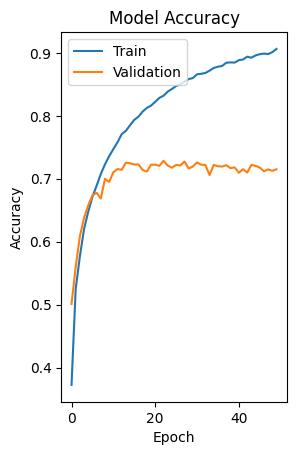

In [17]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

### plot the training and validation loss

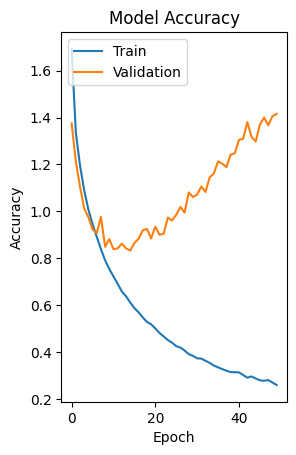

In [18]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [20]:
plt.show()
model.save('cifar10_cnn_model.h5')